In [47]:
# dataset_mapping = {
#     'Durum Wheat': ('Identification (I)', 'F1 Score', 'Crop Type'),
#     'Soybean Seeds': ('Identification (I)', 'F1 Score', 'Crop Type'),
#     'Mango Leaf Disease': ('Identification (I)', 'F1 Score', 'Disease Type'),
#     'Bean Leaf Lesions': ('Identification (I)', 'F1 Score', 'Disease Type'),
#     'DeepWeeds': ('Identification (I)', 'F1 Score', 'Pest Type'),
#     'IP02': ('Identification (I)', 'F1 Score', 'Pest Type'),
#     'SBRD': ('Identification (I)', 'F1 Score', 'Disease Stage'),
#     'Yellow Rust 19': ('Classification (C)', 'NMAE', 'Disease Stage'),
#     'FUSARIUM 22': ('Classification (C)', 'NMAE', 'Leaf Health'),
#     'InsectCount': ('Quantification (Q)', 'NMAE', 'Pest Count'),
#     'PlantDoc': ('Quantification (Q)', 'NMAE', 'Disease Quantification'),
# }




# so the fixed mapping is


In [30]:

# new mapping
dataset_mapping = {
    'Durum Wheat': ('Identification (I)', 'F1', 'Seed Morphology'),
    'Soybean Seeds': ('Identification (I)', 'F1', 'Seed Morphology'),
    'Mango Leaf Disease': ('Identification (I)', 'F1', 'Foliar Stress'),
    'Bean Leaf Lesions': ('Identification (I)', 'F1', 'Foliar Stress'),
    'Soybean Diseases': ('Identification (I)', 'F1', 'Foliar Stress'),
    'Dangerous Insects': ('Identification (I)', 'F1', 'Invasive Species'),
    'DeepWeeds': ('Identification (I)', 'F1', 'Invasive Species'),
    # 'SBRD': ('Identification (I)', 'F1', 'Disease Severity'),
    'Yellow Rust 19': ('Classification (C)', 'NMAE', 'Disease Severity'),
    'IDC': ('Classification (C)', 'NMAE', 'Stress Tolerance'),
    'FUSARIUM 22': ('Classification (C)', 'NMAE', 'Stress Tolerance'),
    'InsectCount': ('Quantification (Q)', 'NMAE', 'Pest'),
    'PlantDoc': ('Quantification (Q)', 'NMAE', 'Disease'),
}



import os
import pandas as pd
import numpy as np
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix, mean_absolute_error

# Define the datasets and their categories, metrics, and subcategories


result_table_dict={}
for this_shot in [0,1,2,4,8]:
    def calculate_metric(df, category, dataset_name):
        print(f"Processing {dataset_name}...")
        true_labels = df['1'].fillna('Unknown')
        pred_labels = df[f'# of Shots {this_shot}'].fillna('NA_placeholder')
        
        if category == 'Identification (I)':
            # Use F1 score for category I
            precision, recall, f1, _ = precision_recall_fscore_support(true_labels, pred_labels, average='weighted', zero_division=0)
            return f1 * 100
        elif category == 'Classification (C)':
            # Use normalized MAE for ordinal classification
            if dataset_name == 'FUSARIUM 22':
                ordinal_map = {
                    'Highly Resistant': 1,
                    'Resistant': 2,
                    'Moderately Resistant': 3,
                    'Susceptible': 4,
                    'Highly Susceptible': 5,
                }
            elif dataset_name == 'Yellow Rust 19':
                ordinal_map = {
                    'Resistant (R)': 1,
                    'Moderately Resistant (MR)': 2,
                    'MRMS': 3,
                    'Moderately Susceptible (MS)': 4,
                    'Susceptible (S)': 5,
                    'No disease (0)': 0,
                }
            elif dataset_name == 'IDC':
                ordinal_map = {i: i for i in range(1, 6)}

            else:
                raise ValueError(f"Unknown dataset for category C: {dataset_name}")
            
            # Add unseen labels to the ordinal map with the worst score
            max_value = max(ordinal_map.values())
            all_labels = set(true_labels).union(set(pred_labels))
            for label in all_labels:
                if label not in ordinal_map:
                    ordinal_map[label] = max_value + 1
            
            true_ordinal = true_labels.map(ordinal_map)
            pred_ordinal = pred_labels.map(ordinal_map)
            
            # Calculate normalized MAE
            mae = np.mean(np.abs(true_ordinal - pred_ordinal))
            max_possible_error = max(ordinal_map.values()) - min(ordinal_map.values())
            if max_possible_error == 0:
                print(f"Warning: All values are the same for {dataset_name}")
                return 0.0  # Perfect prediction if all values are the same
            normalized_mae = (mae / max_possible_error) * 100
            
            return normalized_mae
        elif category == 'Quantification (Q)':
            try:
                true_values = pd.to_numeric(true_labels, errors='coerce')
                pred_values = pd.to_numeric(pred_labels, errors='coerce')
                
                # Remove rows where either true_values or pred_values is NaN
                mask = ~(true_values.isna() | pred_values.isna())
                true_values = true_values[mask]
                pred_values = pred_values[mask]
                
                if len(true_values) == 0:
                    print(f"Warning: No valid numeric data for {dataset_name}")
                    return np.nan
                
                # Calculate MAPE (avoiding division by zero)
                non_zero_mask = true_values != 0
                if non_zero_mask.sum() == 0:
                    print(f"Warning: All true values are zero for {dataset_name}")
                    mape = np.nan
                else:
                    mape = np.mean(np.abs((true_values[non_zero_mask] - pred_values[non_zero_mask]) / true_values[non_zero_mask])) * 100
                
                # Calculate normalized MAE
                mae = np.mean(np.abs(true_values - pred_values))
                max_possible_error = true_values.max() - true_values.min()
                if max_possible_error == 0:
                    print(f"Warning: All values are the same for {dataset_name}")
                    normalized_mae = 0.0  # Perfect prediction if all values are the same
                else:
                    normalized_mae = (mae / max_possible_error) * 100
                
                return normalized_mae  # or return mape, depending on preference
            except Exception as e:
                print(f"Error in quantification for {dataset_name}: {str(e)}")
                return np.nan
    # Get the list of model folders
    model_folders = [f for f in os.listdir('results') if os.path.isdir(os.path.join('results', f))]

    # Initialize results dictionary
    results = {model: {} for model in model_folders}

    # Process each dataset for each model
    for model in model_folders:
        for dataset, (category, metric, subcategory) in dataset_mapping.items():
            try:
                df = pd.read_csv(f'results/{model}/{dataset}.csv', engine='python')
                result = calculate_metric(df, category, dataset)
                results[model][dataset] = result
            except FileNotFoundError:
                print(f"File not found: results/{model}/{dataset}.csv")
                results[model][dataset] = np.nan
            except Exception as e:
                print(f"Error processing {model}/{dataset}: {str(e)}")
                results[model][dataset] = np.nan

    # Create the result table
    result_table = pd.DataFrame(results).T  # Transpose to match the desired format

    # Rename the index and columns
    result_table.index.name = 'Model'
    result_table.columns.name = 'Dataset'

    # Round the results to 2 decimal places
    result_table = result_table.round(2)

    # Create multi-level columns
    columns = pd.MultiIndex.from_tuples([
        (category, metric, subcategory, dataset)
        for dataset, (category, metric, subcategory) in dataset_mapping.items()
    ])

    # Reorder and rename columns
    result_table = result_table.reindex(columns=columns.get_level_values(3))
    result_table.columns = columns

    print(result_table)
    result_table_dict[this_shot]=result_table.copy(deep= True)
    # Optionally, save the result table to a CSV file
    result_table.to_csv(f'analysis/plain-results/result_table_shot_{this_shot}.csv')

Processing Durum Wheat...
Processing Soybean Seeds...
Processing Mango Leaf Disease...
Processing Bean Leaf Lesions...
Processing Soybean Diseases...
Processing Dangerous Insects...
Processing DeepWeeds...
Processing Yellow Rust 19...
Processing IDC...
Processing FUSARIUM 22...
Processing InsectCount...
Processing PlantDoc...
Processing Durum Wheat...
Processing Soybean Seeds...
Processing Mango Leaf Disease...
Processing Bean Leaf Lesions...
Processing Soybean Diseases...
Processing Dangerous Insects...
Processing DeepWeeds...
Processing Yellow Rust 19...
Processing IDC...
Processing FUSARIUM 22...
Processing InsectCount...
Processing PlantDoc...
Processing Durum Wheat...
Processing Soybean Seeds...
Processing Mango Leaf Disease...
Processing Bean Leaf Lesions...
Processing Soybean Diseases...
Processing Dangerous Insects...
Processing DeepWeeds...
Processing Yellow Rust 19...
Processing IDC...
Processing FUSARIUM 22...
Processing InsectCount...
Processing PlantDoc...
Processing Durum

In [17]:
# # # GOOD. DON'T DELETE

# import pandas as pd

# # Assuming your DataFrame is called 'result_table'
# result_table=result_table_dict[0]
# def to_latex_with_multicolumn(df):
#     latex = df.to_latex(multicolumn=True, multicolumn_format='c', multirow=True,
#                         column_format='l' + 'c'*len(df.columns), 
#                         float_format="{:0.2f}".format,
#                         escape=False)
    
#     # Remove the \toprule, \midrule, and \bottomrule commands
#     latex = latex.replace('\\toprule', '\\hline')
#     latex = latex.replace('\\midrule', '\\hline')
#     latex = latex.replace('\\bottomrule', '\\hline')
    
#     return latex

# # Convert to LaTeX
# latex_table = to_latex_with_multicolumn(result_table)

# # Add caption and label
# latex_table = """\\begin{table*}[htbp]
# \\centering
# \\caption{0-shot Performance of Large Language Models on Agricultural Image Datasets}
# \\label{tab:zero_shot_results}
# \\resizebox{\\textwidth}{!}{%
# """ + latex_table + "}\\end{table*}"

# print(latex_table)



\begin{table*}[htbp]
\centering
\caption{0-shot Performance of Large Language Models on Agricultural Image Datasets}
\label{tab:zero_shot_results}
\resizebox{\textwidth}{!}{%
\begin{tabular}{lcccccccccccc}
\hline
 & \multicolumn{7}{c}{Identification (I)} & \multicolumn{3}{c}{Classification (C)} & \multicolumn{2}{c}{Quantification (Q)} \\
 & \multicolumn{7}{c}{F1} & \multicolumn{3}{c}{NMAE} & \multicolumn{2}{c}{NMAE} \\
 & \multicolumn{2}{c}{Seed Morphology} & \multicolumn{3}{c}{Foliar Stress} & \multicolumn{2}{c}{Invasive Species} & Disease Severity & \multicolumn{2}{c}{Stress Tolerance} & Pest & Disease \\
 & Durum Wheat & Soybean Seeds & Mango Leaf Disease & Bean Leaf Lesions & Soybean Diseases & Dangerous Insects & DeepWeeds & Yellow Rust 19 & IDC & FUSARIUM 22 & InsectCount & PlantDoc \\
Model &  &  &  &  &  &  &  &  &  &  &  &  \\
\hline
Gemini-pro-1.5 & 55.56 & 26.24 & 42.91 & 77.22 & 21.78 & 82.67 & 46.83 & 26.25 & 30.87 & 33.00 & 29.00 & 9.57 \\
GPT-4o & 55.10 & 19.00 & 58.41 &

In [31]:
# import pandas as pd

# # Assuming your DataFrame is called 'result_table'
# result_table = result_table_dict[8]

# def to_latex_with_multicolumn(df):
#     latex = df.to_latex(multicolumn=True, multicolumn_format='c', multirow=True,
#                         column_format='l' + 'c'*len(df.columns), 
#                         float_format="{:0.2f}".format,
#                         escape=False)
    
#     # Remove the \toprule, \midrule, and \bottomrule commands
#     latex = latex.replace('\\toprule', '\\hline')
#     latex = latex.replace('\\midrule', '\\hline')
#     latex = latex.replace('\\bottomrule', '\\hline')
    
#     # Remove the first two rows
#     lines = latex.split('\n')
#     lines = lines[:2] + lines[4:]  # Keep the first two lines (begin{tabular} and hline), then skip two rows
#     latex = '\n'.join(lines)
    
#     return latex

# # Split the DataFrame
# identification_columns = result_table.columns.get_level_values(0) == 'Identification (I)'
# identification_table = result_table.loc[:, identification_columns]

# classification_quantification_columns = result_table.columns.get_level_values(0).isin(['Classification (C)', 'Quantification (Q)'])
# classification_quantification_table = result_table.loc[:, classification_quantification_columns]

# # Convert to LaTeX
# latex_table_identification = to_latex_with_multicolumn(identification_table)
# latex_table_classification_quantification = to_latex_with_multicolumn(classification_quantification_table)

# # Combine the tables into a single table with subtables
# combined_latex_table = """\\begin{table*}[htbp]
# \\centering
# \\caption{8-shot Performance of Large Language Models on AgEval Benchmark}
# \\label{tab:eight_shot_results}

# \\begin{subtable}{1\\textwidth}
# \\centering
# {\\fontsize{7pt}{8pt}\\selectfont
# """ + latex_table_identification + """}
# \\caption{Identification - Metric: F1 Score (Higher is Better)}
# \\label{tab:eight_shot_results_identification}
# \\end{subtable}

# \\bigskip

# \\begin{subtable}{1\\textwidth}
# \\centering
# {\\fontsize{7pt}{8pt}\\selectfont
# """ + latex_table_classification_quantification + """}
# \\caption{Classification and Quantification - Metric: NMSE (Lower is Better)}
# \\label{tab:eight_shot_results_classification_quantification}
# \\end{subtable}

# \\end{table*}"""

# print(combined_latex_table)

\begin{table*}[htbp]
\centering
\caption{8-shot Performance of Large Language Models on AgEval Benchmark}
\label{tab:eight_shot_results}

\begin{subtable}{1\textwidth}
\centering
{\fontsize{7pt}{8pt}\selectfont
\begin{tabular}{lccccccc}
\hline
 & \multicolumn{2}{c}{Seed Morphology} & \multicolumn{3}{c}{Foliar Stress} & \multicolumn{2}{c}{Invasive Species} \\
 & Durum Wheat & Soybean Seeds & Mango Leaf Disease & Bean Leaf Lesions & Soybean Diseases & Dangerous Insects & DeepWeeds \\
Model &  &  &  &  &  &  &  \\
\hline
Gemini-pro-1.5 & 79.66 & 52.19 & 71.68 & 78.17 & 24.41 & 82.98 & 49.96 \\
GPT-4o & 95.94 & 48.29 & 80.96 & 86.90 & 62.96 & 82.56 & 56.03 \\
LLaVA v1.6 34B & 46.80 & 23.10 & 22.84 & 48.50 & 10.53 & 12.08 & 13.23 \\
Claude-3.5-sonnet & 89.66 & 51.17 & 61.68 & 84.78 & 11.07 & 81.89 & 27.17 \\
Gemini-flash-1.5 & 83.70 & 48.09 & 64.66 & 73.42 & 23.67 & 82.72 & 41.89 \\
Claude-3-haiku & 53.29 & 38.02 & 38.92 & 46.42 & 8.81 & 45.08 & 15.34 \\
\hline
\end{tabular}
}
\caption{Iden

# previous with color highlighting

In [44]:
import pandas as pd
import numpy as np

# Assuming your DataFrame is called 'result_table'
result_table = result_table_dict[0]

def highlight_max_values(s):
    is_max = s == s.max()
    is_second_max = s == s.nlargest(2).min()
    return ['\\cellcolor{yellow!25}' if v else '\\cellcolor{gray!25}' if s else '' for v, s in zip(is_max, is_second_max)]

def highlight_min_values(s):
    is_min = s == s.min()
    is_second_min = s == s.nsmallest(2).max()
    return ['\\cellcolor{yellow!25}' if v else '\\cellcolor{gray!25}' if s else '' for v, s in zip(is_min, is_second_min)]

def to_latex_with_multicolumn(df, highlight_function):
    # Create a copy of the DataFrame to avoid modifying the original
    df_highlighted = df.copy()

    # Apply highlighting to each column
    for col in df_highlighted.columns:
        if df_highlighted[col].dtype in [np.float64, np.int64]:
            highlights = highlight_function(df_highlighted[col])
            df_highlighted[col] = df_highlighted[col].astype(str).radd(highlights)

    latex = df_highlighted.to_latex(multicolumn=True, multicolumn_format='c', multirow=True,
                        column_format='l' + 'c'*len(df_highlighted.columns), 
                        float_format="{:0.2f}".format,
                        escape=False)
    
    # Remove the \toprule, \midrule, and \bottomrule commands
    latex = latex.replace('\\toprule', '\\hline')
    latex = latex.replace('\\midrule', '\\hline')
    latex = latex.replace('\\bottomrule', '\\hline')
    
    # Remove the first two rows
    lines = latex.split('\n')
    lines = lines[:2] + lines[4:]  # Keep the first two lines (begin{tabular} and hline), then skip two rows
    latex = '\n'.join(lines)
    
    return latex

# Split the DataFrame
identification_columns = result_table.columns.get_level_values(0) == 'Identification (I)'
identification_table = result_table.loc[:, identification_columns]

classification_quantification_columns = result_table.columns.get_level_values(0).isin(['Classification (C)', 'Quantification (Q)'])
classification_quantification_table = result_table.loc[:, classification_quantification_columns]

# Convert to LaTeX
latex_table_identification = to_latex_with_multicolumn(identification_table, highlight_max_values)
latex_table_classification_quantification = to_latex_with_multicolumn(classification_quantification_table, highlight_min_values)

# Combine the tables into a single table with subtables
combined_latex_table = """\\begin{table*}[htbp]
\\centering
\\caption{0-shot Performance of Large Language Models on AgEval Benchmark}
\\label{tab:zero_shot_results}

\\begin{subtable}{1\\textwidth}
\\centering
{\\fontsize{7pt}{8pt}\\selectfont
""" + latex_table_identification + """}
\\caption{Identification - Metric: F1 Score (Higher is Better). 
\\protect\\colorbox{yellow!25}{\\strut Highest} 
\\protect\\colorbox{gray!25}{\\strut Second Highest}}
\\label{tab:zero_shot_results_identification}
\\end{subtable}

\\bigskip

\\begin{subtable}{1\\textwidth}
\\centering
{\\fontsize{7pt}{8pt}\\selectfont
""" + latex_table_classification_quantification + """}
\\caption{Classification and Quantification - Metric: NMSE (Lower is Better). 
\\protect\\colorbox{yellow!25}{\\strut Lowest} 
\\protect\\colorbox{gray!25}{\\strut Second Lowest}}
\\label{tab:zero_shot_results_classification_quantification}
\\end{subtable}

\\end{table*}"""

print(combined_latex_table)

\begin{table*}[htbp]
\centering
\caption{0-shot Performance of Large Language Models on AgEval Benchmark}
\label{tab:zero_shot_results}

\begin{subtable}{1\textwidth}
\centering
{\fontsize{7pt}{8pt}\selectfont
\begin{tabular}{lccccccc}
\hline
 & \multicolumn{2}{c}{Seed Morphology} & \multicolumn{3}{c}{Foliar Stress} & \multicolumn{2}{c}{Invasive Species} \\
 & Durum Wheat & Soybean Seeds & Mango Leaf Disease & Bean Leaf Lesions & Soybean Diseases & Dangerous Insects & DeepWeeds \\
Model &  &  &  &  &  &  &  \\
\hline
Gemini-pro-1.5 & \cellcolor{yellow!25}55.56 & 26.24 & 42.91 & \cellcolor{yellow!25}77.22 & \cellcolor{yellow!25}21.78 & \cellcolor{gray!25}82.67 & \cellcolor{yellow!25}46.83 \\
GPT-4o & 55.1 & 19.0 & \cellcolor{yellow!25}58.41 & 65.92 & 3.7 & \cellcolor{yellow!25}82.79 & \cellcolor{gray!25}38.77 \\
LLaVA v1.6 34B & 40.56 & 13.74 & 13.63 & 44.03 & 8.54 & 18.54 & 8.68 \\
Claude-3.5-sonnet & \cellcolor{yellow!25}55.56 & \cellcolor{yellow!25}38.7 & \cellcolor{gray!25}49.82 & 6

In [51]:
import pandas as pd
import numpy as np

def calculate_ranks_and_mrr(df):
    def rank_column(col):
        if col.name[0] in ['Classification (C)', 'Quantification (Q)']:
            return col.rank()  # Lower is better for these categories
        else:
            return col.rank(ascending=False)  # Higher is better for Identification

    # Calculate ranks for each dataset
    ranks = df.apply(rank_column)

    # Separate ranks for Identification and Classification+Quantification
    id_ranks = ranks.loc[:, ranks.columns.get_level_values(0) == 'Identification (I)']
    cq_ranks = ranks.loc[:, ranks.columns.get_level_values(0).isin(['Classification (C)', 'Quantification (Q)'])]

    # Calculate MRR for each category
    mrr_id = (1 / id_ranks).mean(axis=1)
    mrr_cq = (1 / cq_ranks).mean(axis=1)

    # Calculate average ranks
    avg_rank_id = id_ranks.mean(axis=1)
    avg_rank_cq = cq_ranks.mean(axis=1)

    return pd.DataFrame({
        'Avg Rank (ID)': avg_rank_id,
        'MRR (ID)': mrr_id,
        'Avg Rank (CQ)': avg_rank_cq,
        'MRR (CQ)': mrr_cq
    })

# Calculate metrics for 0-shot and 8-shot
results_0shot = calculate_ranks_and_mrr(result_table_dict[0])
results_8shot = calculate_ranks_and_mrr(result_table_dict[8])

# Combine results into a single DataFrame
combined_results = pd.concat([
    results_0shot.add_suffix(' (0-shot)'),
    results_8shot.add_suffix(' (8-shot)')
], axis=1)

# Sort the DataFrame by the average of 8-shot MRR scores
combined_results['Avg 8-shot MRR'] = (combined_results['MRR (ID) (8-shot)'] + combined_results['MRR (CQ) (8-shot)']) / 2
combined_results = combined_results.sort_values('Avg 8-shot MRR', ascending=False)

# Reorder columns
column_order = [
    'Avg Rank (ID) (0-shot)', 'MRR (ID) (0-shot)', 'Avg Rank (CQ) (0-shot)', 'MRR (CQ) (0-shot)',
    'Avg Rank (ID) (8-shot)', 'MRR (ID) (8-shot)', 'Avg Rank (CQ) (8-shot)', 'MRR (CQ) (8-shot)',
    'Avg 8-shot MRR'
]
combined_results = combined_results[column_order]

# Format the DataFrame
pd.set_option('display.float_format', '{:.3f}'.format)
combined_results.head(10)

,Avg Rank (ID) (0-shot),MRR (ID) (0-shot),Avg Rank (CQ) (0-shot),MRR (CQ) (0-shot),Avg Rank (ID) (8-shot),MRR (ID) (8-shot),Avg Rank (CQ) (8-shot),MRR (CQ) (8-shot),Avg 8-shot MRR
Model,,,,,,,,,
GPT-4o,3.143,0.493,2.400,0.700,1.571,0.810,2.900,0.553,0.681
Gemini-pro-1.5,1.786,0.690,4.200,0.373,2.143,0.583,2.800,0.467,0.525
Claude-3.5-sonnet,2.714,0.472,2.400,0.540,3.143,0.357,1.800,0.667,0.512
Gemini-flash-1.5,3.286,0.333,3.000,0.367,3.143,0.333,2.800,0.383,0.358
Claude-3-haiku,4.429,0.257,4.400,0.247,5.286,0.190,5.000,0.203,0.197
LLaVA v1.6 34B,5.643,0.179,4.600,0.223,5.714,0.176,5.700,0.176,0.176


# plotting MRR

In [64]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams.update({
    'font.family': 'Arial',
    'font.size': 8,
    'axes.labelsize': 9,
    'axes.titlesize': 10,
    'xtick.labelsize': 7,
    'ytick.labelsize': 7,
    'legend.fontsize': 8,
})

def calculate_ranks_and_mrr(df):
    def rank_column(col):
        if col.name[0] in ['Classification (C)', 'Quantification (Q)']:
            return col.rank()  # Lower is better for these categories
        else:
            return col.rank(ascending=False)  # Higher is better for Identification

    ranks = df.apply(rank_column)
    id_ranks = ranks.loc[:, ranks.columns.get_level_values(0) == 'Identification (I)']
    cq_ranks = ranks.loc[:, ranks.columns.get_level_values(0).isin(['Classification (C)', 'Quantification (Q)'])]

    mrr_id = (1 / id_ranks).mean(axis=1)
    mrr_cq = (1 / cq_ranks).mean(axis=1)

    return pd.DataFrame({
        'MRR (ID)': mrr_id,
        'MRR (CQ)': mrr_cq
    })

# Calculate metrics for 0-shot and 8-shot
results_0shot = calculate_ranks_and_mrr(result_table_dict[0])
results_8shot = calculate_ranks_and_mrr(result_table_dict[8])

def plot_performance(data, shot):
    fig, ax = plt.subplots(figsize=(4, 3))
    bar_width = 0.35
    opacity = 0.8

    index = np.arange(len(data.index))
    
    ax.bar(index - bar_width/2, data['MRR (ID)'], bar_width,
           alpha=opacity, color='skyblue', label='Identification')
    ax.bar(index + bar_width/2, data['MRR (CQ)'], bar_width,
           alpha=opacity, color='lightgreen', label='Classification & Quantification')

    ax.set_xlabel('Models')
    ax.set_ylabel('Mean Reciprocal Rank (MRR)')
    ax.set_title(f'{shot}-shot Performance')
    ax.set_xticks(index)
    ax.set_xticklabels(data.index, rotation=45, ha='right')
    ax.legend(loc='upper right')#, bbox_to_anchor=(0, 1.02))

    # Set y-axis limits based on the data
    y_min = min(data['MRR (ID)'].min(), data['MRR (CQ)'].min())
    y_max = max(data['MRR (ID)'].max(), data['MRR (CQ)'].max())
    ax.set_ylim(max(0, y_min - 0.1), min(1, y_max + 0.1))

    plt.tight_layout()
    plt.savefig(f'analysis/overall-performance/{shot}_shot.pdf', dpi=300, bbox_inches='tight')
    plt.close()

# Sort models by average MRR across all categories for 8-shot
avg_mrr_8shot = results_8shot.mean(axis=1)
model_order = avg_mrr_8shot.sort_values(ascending=False).index

# Plot 0-shot performance
plot_performance(results_0shot.loc[model_order], '0')

# Plot 8-shot performance
plot_performance(results_8shot.loc[model_order], '8')

print("Plots have been generated and saved.")

Plots have been generated and saved.


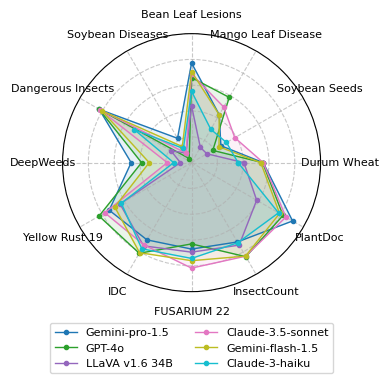

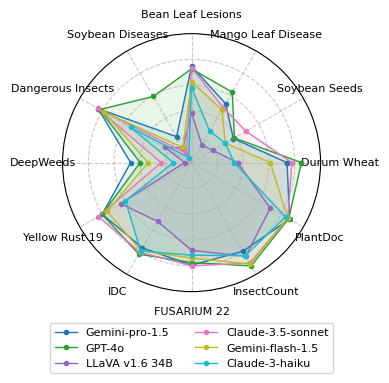

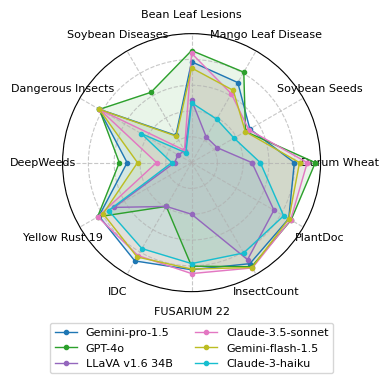

In [33]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

for shot in [0,2,8]:
    # Assuming result_table is already defined as per your provided data
    result_table=result_table_dict[shot]
    # Prepare the data
    models = result_table.index.tolist()
    datasets = result_table.columns.get_level_values(3).tolist()
    metrics = result_table.columns.get_level_values(1).tolist()
    values = result_table.values

    # Normalize the values based on the metric
    normalized_values = np.zeros_like(values)
    for i, metric in enumerate(metrics):
        # normalized_values[:, i] = values[:, i]
        if metric == 'F1':
            normalized_values[:, i] = values[:, i] 
        elif metric == 'NMAE':
            normalized_values[:, i] = 100-values[:, i]

    # Remove columns with all NaN values
    valid_columns = ~np.all(np.isnan(normalized_values), axis=0)
    normalized_values = normalized_values[:, valid_columns]
    datasets = [d for d, v in zip(datasets, valid_columns) if v]

    # Set up the angles for each dataset
    angles = np.linspace(0, 2*np.pi, len(datasets), endpoint=False)

    # Close the plot by appending the first value to the end
    normalized_values = np.concatenate((normalized_values, normalized_values[:, [0]]), axis=1)
    angles = np.concatenate((angles, [angles[0]]))

    # Set up the plot
    fig, ax = plt.subplots(figsize=(5, 4), subplot_kw=dict(projection='polar'))

    # Color cycle for the models
    colors = plt.cm.tab10(np.linspace(0, 1, len(models)))
    ax.set_ylim(0, 100)  # Set the range from 0 to 100

    # Plot each model
    for i, model in enumerate(models):
        ax.plot(angles, normalized_values[i], 'o-', linewidth=1, color=colors[i], label=model, markersize=3)
        ax.fill(angles, normalized_values[i], alpha=0.1, color=colors[i])

    # Set the labels
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(datasets, fontsize=8)

    # Remove radial labels and set grid
    ax.set_yticklabels([])
    ax.grid(True, linestyle='--', alpha=0.7)

    # Adjust the subplot layout
    plt.subplots_adjust(bottom=0.1, top=0.9)

    # Create legend
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), fontsize=8, ncol=2)

    # Adjust layout and save
    plt.tight_layout()
    plt.savefig(f'analysis/radar_plots/{shot}.pdf', dpi=300, bbox_inches='tight')
    plt.show()

In [39]:
result_table_dict[0].head()

Identification (I)                                   \
                           F1 Score                                    
                          Crop Type                     Disease Type   
                        Durum Wheat Soybean Seeds Mango Leaf Disease   
Model                                                                  
GPT-4o                        59.24         23.96              62.74   
LLaVA v1.6 34B                30.45         28.19              15.59   
Gemini-flash-1.5              46.18         26.12              55.71   
Claude-3-haiku                41.27         36.41              17.59   
Claude-3-sonnet               39.25         29.44              18.07   

                                                                   \
                                                                    
                                   Pest Type        Disease Stage   
                 Bean Leaf Lesions DeepWeeds   IP02          SBRD   
Model                                                               
GPT-4o                       80.26     24.21  19.61         44.14   
LLaVA v1.6 34B               51.21      8.73   0.00          5.56   
Gemini-flash-1.5             73.33     39.14  17.81         16.30   
Claude-3-haiku               54.73      6.95    NaN         12.06   
Claude-3-sonnet              48.29      7.77    NaN         22.22   

                 Classification (C)             Quantification (Q)  \
                               NMAE                           NMAE   
                      Disease Stage Leaf Health         Pest Count   
                     Yellow Rust 19 FUSARIUM 22        InsectCount   
Model                                                                
GPT-4o                        20.00       32.50               32.0   
LLaVA v1.6 34B                34.67       24.67                NaN   
Gemini-flash-1.5              34.00       21.67               22.0   
Claude-3-haiku                34.67       20.83                NaN   
Claude-3-sonnet               33.33         NaN                NaN   

                                         
                                         
                 Disease Quantification  
                               PlantDoc  
Model                                    
GPT-4o                            39.92  
LLaVA v1.6 34B                      NaN  
Gemini-flash-1.5                  77.40  
Claude-3-haiku                      NaN  
Claude-3-sonnet                     NaN

# individual plots for each dataset

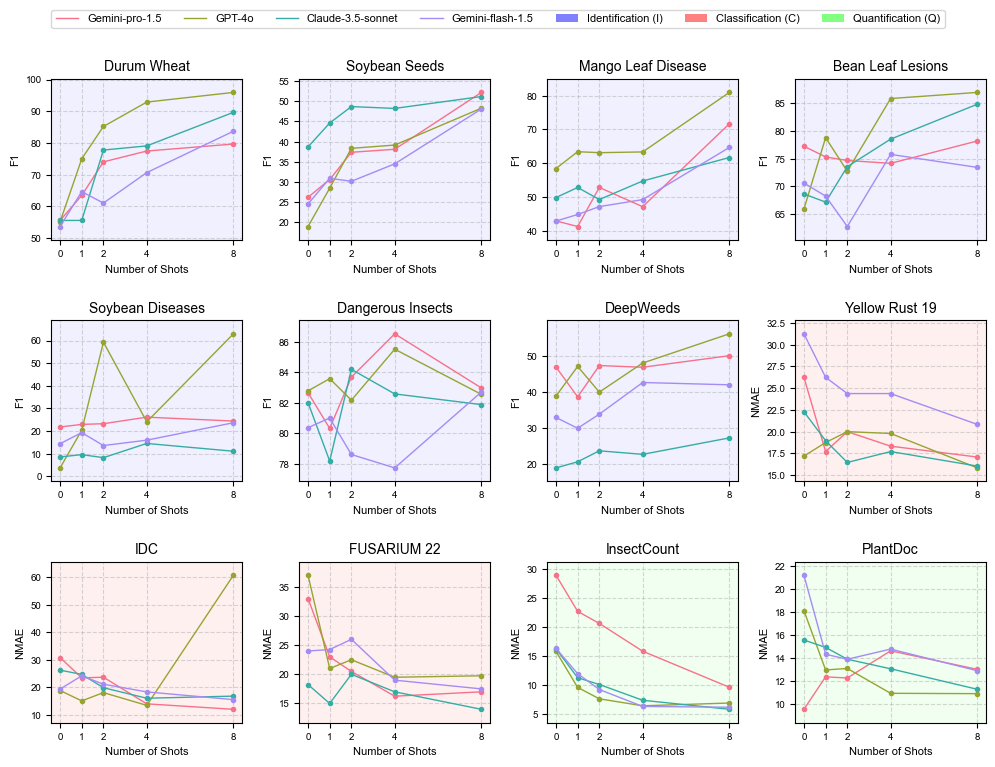

In [36]:
# import matplotlib.pyplot as plt
# import seaborn as sns
# import math
# import numpy as np
# import matplotlib.patches as mpatches
# import matplotlib.gridspec as gridspec

# # Set up the plot style
# plt.rcParams.update({
#     'font.family': 'Arial',
#     'font.size': 8,
#     'axes.labelsize': 9,
#     'axes.titlesize': 10,
#     'xtick.labelsize': 7,
#     'ytick.labelsize': 7,
#     'legend.fontsize': 8,
# })

# # Prepare data
# shots = [0, 1, 2, 4, 8]
# models = [model for model in result_table_dict[0].index if model not in  ('LLaVA v1.6 34B', 'Claude-3-haiku')]
# datasets = [dataset for dataset in result_table_dict[0].columns if dataset[3] != 'IP02']

# # Set up the grid
# n_datasets = len(datasets)
# n_cols = 4
# n_rows = math.ceil(n_datasets / n_cols)

# # Create the main figure
# fig = plt.figure(figsize=(10, 2.5 * n_rows))

# # Use GridSpec for more control over subplot positioning
# gs = gridspec.GridSpec(n_rows, n_cols)

# # Color palette for models
# model_colors = sns.color_palette("husl", n_colors=len(models))

# # Background colors for problem types (subtle for subplots)
# bg_colors = {
#     'Identification (I)': '#f0f0ff',
#     'Classification (C)': '#fff0f0',
#     'Quantification (Q)': '#f0fff0'
# }

# # Intense colors for problem types (for legend)
# legend_colors = {
#     'Identification (I)': '#8080ff',
#     'Classification (C)': '#ff8080',
#     'Quantification (Q)': '#80ff80'
# }

# # Plot each dataset
# for i, dataset in enumerate(datasets):
#     row = i // n_cols
#     col = i % n_cols
    
#     # Center the plots in the last row
#     if row == n_rows - 1:
#         n_plots_last_row = n_datasets - (n_rows - 1) * n_cols
#         offset = (n_cols - n_plots_last_row) // 2
#         ax = fig.add_subplot(gs[row, col + offset])
#     else:
#         ax = fig.add_subplot(gs[row, col])
    
#     ax.set_facecolor(bg_colors[dataset[0]])
    
#     all_values = []
#     for j, model in enumerate(models):
#         values = [result_table_dict[shot].loc[model, dataset] for shot in shots]
#         all_values.extend(values)
#         ax.plot(shots, values, marker='o', markersize=3, linewidth=1, color=model_colors[j])
    
#     ax.set_title(f'{dataset[3]}', fontsize=10)
#     ax.set_xlabel('Number of Shots', fontsize=8)
#     ax.set_ylabel(dataset[1], fontsize=8)
#     ax.tick_params(axis='both', which='major', labelsize=7)
    
#     # Set y-axis limits dynamically
#     y_min, y_max = min(all_values), max(all_values)
#     y_range = y_max - y_min
#     ax.set_ylim(y_min - 0.1 * y_range, y_max + 0.1 * y_range)

#     # Add grid lines
#     ax.grid(True, linestyle='--', alpha=0.5)
    
#     # Set x-axis ticks
#     ax.set_xticks(shots)

# # Create a custom legend
# legend_elements = [plt.Line2D([0], [0], color=model_colors[i], lw=1, label=model) 
#                    for i, model in enumerate(models)]

# # Add problem type legend with intense colors
# problem_type_patches = [mpatches.Patch(facecolor=color, edgecolor='none', label=ptype) 
#                         for ptype, color in legend_colors.items()]
# legend_elements.extend(problem_type_patches)

# fig.legend(handles=legend_elements, loc='upper center', bbox_to_anchor=(0.5, 1.02), 
#            ncol=len(models) + len(bg_colors), fontsize=8)

# # Adjust the layout
# plt.tight_layout()
# plt.subplots_adjust(top=0.92, hspace=0.5, wspace=0.3)  # Make room for the legend and adjust spacing

# # Save the figure
# plt.savefig('analysis/individual_plots.pdf', bbox_inches='tight')
# # Show the plot
# plt.show()

# Making plot for individual dataset seperately

In [39]:


import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score
plt.rcParams.update({
    'font.family': 'Arial',
    'font.size': 8,
    'axes.labelsize': 9,
    'axes.titlesize': 10,
    'xtick.labelsize': 7,
    'ytick.labelsize': 7,
    'legend.fontsize': 8,
})
# Define the datasets and their categories, metrics, and subcategories

# new mapping
dataset_mapping = {
    'Durum Wheat': ('Identification (I)', 'F1', 'Seed Morphology'),
    'Soybean Seeds': ('Identification (I)', 'F1', 'Seed Morphology'),
    'Mango Leaf Disease': ('Identification (I)', 'F1', 'Foliar Stress'),
    'Bean Leaf Lesions': ('Identification (I)', 'F1', 'Foliar Stress'),
    'Soybean Diseases': ('Identification (I)', 'F1', 'Foliar Stress'),
    'Dangerous Insects': ('Identification (I)', 'F1', 'Invasive Species'),
    'DeepWeeds': ('Identification (I)', 'F1', 'Invasive Species'),
    # 'SBRD': ('Identification (I)', 'F1', 'Disease Severity'),
    'Yellow Rust 19': ('Classification (C)', 'NMAE', 'Disease Severity'),
    'IDC': ('Classification (C)', 'NMAE', 'Stress Tolerance'),
    'FUSARIUM 22': ('Classification (C)', 'NMAE', 'Stress Tolerance'),
    'InsectCount': ('Quantification (Q)', 'NMAE', 'Pest'),
    'PlantDoc': ('Quantification (Q)', 'NMAE', 'Disease'),
}



def calculate_f1_scores(true_labels, pred_labels):
    classes = np.unique(true_labels)
    f1_scores = {}
    for cls in classes:
        true_binary = (true_labels == cls)
        pred_binary = (pred_labels == cls)
        f1 = f1_score(true_binary, pred_binary, zero_division=0)
        f1_scores[cls] = f1
    return f1_scores

# Get the list of model folders
model_folders = [f for f in os.listdir('results') if os.path.isdir(os.path.join('results', f))]

# Initialize results dictionary
results = {model: {} for model in model_folders}

# Process each dataset for each model
for model in model_folders:
    for dataset, (category, metric, subcategory) in dataset_mapping.items():
        if category == 'Quantification (Q)':
            continue  # Skip quantification for now
        try:
            df = pd.read_csv(f'results/{model}/{dataset}.csv', engine='python')
            true_labels = df['1'].fillna('Unknown').astype(str)
            zero_shot = df['# of Shots 0'].fillna('NA_placeholder').astype(str)
            eight_shot = df['# of Shots 8'].fillna('NA_placeholder').astype(str)
            
            f1_zero = calculate_f1_scores(true_labels, zero_shot)
            f1_eight = calculate_f1_scores(true_labels, eight_shot)
            
            # Sort categories by 0-shot F1 score
            sorted_zero = sorted(f1_zero.items(), key=lambda x: x[1], reverse=True)
            
            # Get highest, median, and lowest performing categories based on 0-shot
            n = len(sorted_zero)
            highest = sorted_zero[0][0]
            median = sorted_zero[n//2][0]
            lowest = sorted_zero[-1][0]
            
            results[model][dataset] = {
                '0-shot': {
                    'Highest': {'category': highest, 'score': f1_zero[highest]},
                    'Median': {'category': median, 'score': f1_zero[median]},
                    'Lowest': {'category': lowest, 'score': f1_zero[lowest]}
                },
                '8-shot': {
                    'Highest': {'category': highest, 'score': f1_eight[highest]},
                    'Median': {'category': median, 'score': f1_eight[median]},
                    'Lowest': {'category': lowest, 'score': f1_eight[lowest]}
                }
            }
        except Exception as e:
            print(f"Error processing {model}/{dataset}: {str(e)}")
            results[model][dataset] = {
                '0-shot': {
                    'Highest': {'category': 'N/A', 'score': np.nan},
                    'Median': {'category': 'N/A', 'score': np.nan},
                    'Lowest': {'category': 'N/A', 'score': np.nan}
                },
                '8-shot': {
                    'Highest': {'category': 'N/A', 'score': np.nan},
                    'Median': {'category': 'N/A', 'score': np.nan},
                    'Lowest': {'category': 'N/A', 'score': np.nan}
                }
            }

def create_plot(dataset, results):
    fig, ax = plt.subplots(figsize=(6, 3))  # Decreased figure size to half
    bar_width = 0.15
    opacity = 0.8
    padding = 0.02  # 2% padding for empty or zero values

    performances = ['Highest', 'Median', 'Lowest']
    num_models = len(model_folders)
    
    for p_idx, performance in enumerate(performances):
        for m_idx, model in enumerate(model_folders):
            zero_shot = results[model][dataset]['0-shot'][performance]['score']
            eight_shot = results[model][dataset]['8-shot'][performance]['score']
            category = results[model][dataset]['0-shot'][performance]['category']
            
            x = p_idx * (num_models + 1) * bar_width + m_idx * bar_width
            
            # Add padding for empty or zero values
            zero_shot = max(zero_shot, padding) if not np.isnan(zero_shot) else padding
            eight_shot = max(eight_shot, padding) if not np.isnan(eight_shot) else padding
            
            ax.bar(x, zero_shot, bar_width, alpha=opacity, color=plt.cm.Set3(m_idx), 
                   label=model if p_idx == 0 else "", hatch='')
            ax.bar(x, eight_shot, bar_width, alpha=opacity, color=plt.cm.Set3(m_idx), 
                   hatch='/////', bottom=zero_shot)
        
        # Add category name
        x_center = p_idx * (num_models + 1) * bar_width + (num_models - 1) * bar_width / 2
        ax.text(x_center, -0.05, f"{performance}\n({category})", ha='center', va='top', transform=ax.get_xaxis_transform())

    ax.set_ylabel('F1 Score')
    ax.set_title(f'F1 Scores for {dataset}')
    ax.set_ylim(0, 1)  # Assuming F1 scores are between 0 and 1
    
    # Remove x-axis ticks
    ax.set_xticks([])
    
    # Add a legend for models
    legend = ax.legend(title="Models", bbox_to_anchor=(1.05, 1), loc='upper left')
    
    # Add clarification for 0-shot and 8-shot under the legend
    ax.text(1.05, 0, 'Solid: 0-shot F1 Score \n /////  : 8-shot Additional Gain in F1', transform=ax.transAxes, 
            verticalalignment='bottom', horizontalalignment='left')

    plt.tight_layout()
    plt.savefig(f'analysis/individual_bar_plots/{dataset}_f1_scores.pdf', dpi=300, bbox_inches='tight')
    plt.close()

# Generate plots
for dataset, (category, metric, subcategory) in dataset_mapping.items():
    if category == 'Quantification (Q)':
        continue
    create_plot(dataset, results)

print("Plots have been generated and saved.")


Plots have been generated and saved.
